In [2]:
%matplotlib inline 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import math

In [3]:
# always one feature for the moment (simplification)
d = 1

In [4]:
# characteristic functions 
def g1(x):
    return x

def g2(x):
     return np.power(x,2)

def g3(x):
    return np.power(x,3)

def g_mix(x):
    return np.power(x,5) - np.power(x,2)

In [5]:
# generate X as standard distribution
def generate_X(p, d=1):
    return np.random.normal(size = (p, d))

### Generate factors using VAR model

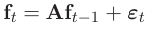

In [6]:
def generate_F(T, K):

    A = np.random.random((K,K))

    def rec(f, K=K):
        return A.dot(f.transpose()) + np.random.normal(size=(K,1))
    
    F = np.random.normal(size = (1,K))
    
    for _ in range(T-1):
        F = np.concatenate((F, rec(F[-1, :].reshape(1, K)).transpose()), axis=0)

    return F

In [7]:
def generate_Gx(X, functions):
    Gx = np.concatenate([g(X) for g in functions], axis = 1)
    return Gx 

### Generate returns using factor model 
### $\Gamma$ = 0 and $U = 0$ (simplification)

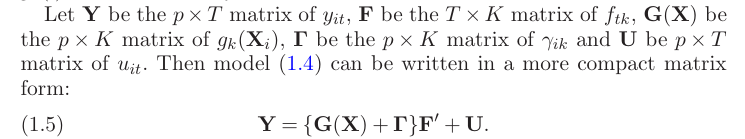

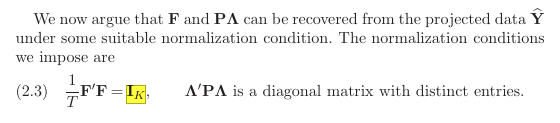

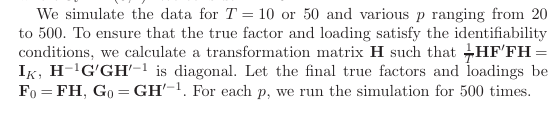

In [8]:
def gen_simulated_data(p, T, functions, d=1):
    K = len(functions)

    X = generate_X(p, d=1)
    F = generate_F(T, K=K)
    G = generate_Gx(X, functions) 
    
    # normalizing F, thanks Constant
    val, vect = np.linalg.eigh(F.T @ F)
    O = vect.T  
    
    D = np.zeros((K, K)) 
    np.fill_diagonal(D, val)

    print(np.linalg.det(np.sqrt(D) @ O))
    H = np.linalg.inv(np.sqrt(D) @ O) * np.sqrt(T)

    F = F @ H
    # print((F.T @ F)/T) # Ik

    # ** maybe G.T @ G should be diagonal **
    # G = G @ np.linalg.inv(H.T)
    # print(G.T @ G)
    
    if F.mean() < 0:
        F = -F
    # print(F.mean()) # positive

    Y = G @ F.T

    return X, Y, F

# G = F D F^T

In [9]:
T = 20
p = 40
functions = [g1, g3]

# val propres positives is necessary
X, Y, F = gen_simulated_data(p, T, functions, d=1)

-54.504268517800675


In [10]:
def u_col(T):
    def get_near_psd(A):
        C = (A + A.T)/2
        eigval, eigvec = np.linalg.eig(C)
        eigval[eigval < 0] = 0

        return eigvec @ np.diag(eigval) @ eigvec.T
    D = np.diag(np.random.beta(7,500, size = T))
    Sigma = np.random.normal(scale = 0.15, size = (T,T))
    np.fill_diagonal(Sigma, 0)
    return np.random.multivariate_normal(mean = np.zeros(T), cov = get_near_psd(D @ Sigma @ D))


U = np.concatenate([[u_col(T)] for _ in range(p)], axis = 0)
U.shape

(40, 20)

In [11]:
# GENERATE CSV

# create data frame
charact = pd.DataFrame(X, columns=[f'char {x}' for x in range(1, X.shape[1]+1)])
ret = pd.DataFrame(Y)

# reindex, rename
charact.index = ret.index = np.arange(1, len(ret)+1)
ret.columns = np.arange(1, ret.shape[1]+1)
charact.index.name = ret.index.name = 'Stock(p)'

# to_csv
ret.to_csv('data_simulation/return.csv', index=False) 
charact.to_csv('data_simulation/1.csv', index=False)

### Does linear regression really fails? (non linear cases)
### Are X and Y minimally correlated?

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)

reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
print("~ Linreg :")
print("R2 = " + str(reg.score(X_test, y_test)))
print("MSE = " + str(mean_squared_error(y_test, y_pred)))
print("MAE = " + str(mean_absolute_error(y_test, y_pred)))

rfr = RandomForestRegressor(random_state = 42).fit(X_train, y_train)
y_pred = rfr.predict(X_test)
print("\n~ RandomForest :")
print("R2 = " + str(rfr.score(X_test, y_test)))
print("MSE = " + str(mean_squared_error(y_test, y_pred)))
print("MAE = " + str(mean_absolute_error(y_test, y_pred)))

~ Linreg :
R2 = 0.6670822527187965
MSE = 1.9393887750561098
MAE = 1.0026230886651484

~ RandomForest :
R2 = 0.8801492358974826
MSE = 0.8194635603465301
MAE = 0.315898078583964


In [13]:
# testing linearity (times f parameter)

def get_error(f, model, metric, n_iterations):
    X, Y = gen_simulated_data(p, T, f)
    error = 0
    for i in range(n_iterations):
        X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.25)
        reg = model().fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        error += metric(y_test, y_pred)
    return error/n_iterations

def plot_linearity_coefficient(metric, n_iterations, metric_name):
    fs = np.linspace(0, 1, 50)
    # plt.subplot(2, 1, 1)
    errors_reg = np.asarray([get_error(f, LinearRegression, metric, n_iterations) for f in fs])
    errors_rfr = np.asarray([get_error(f, RandomForestRegressor, metric, n_iterations) for f in fs])

    plt.xlabel("linearity coefficient f")
    plt.ylabel(metric_name)
    plt.scatter(fs, errors_reg, label = "Linear Regression")
    a, b = np.polyfit(fs, errors_reg, 1)
    # plt.hlines(xmin=0, xmax=1, y=errors_reg.mean(), linestyles="dashed")
    plt.plot(fs, a*fs+b, label = "best fit line for LR")
    plt.scatter(fs, errors_rfr, label = "Random Forest") 
    a, b = np.polyfit(fs, errors_rfr, 1)
    # plt.hlines(xmin=0, xmax=1, y=errors_rfr.mean(), linestyles="dashed")
    plt.plot(fs, a*fs+b, label = "best fit line for RF")
    plt.legend()
 

In [15]:
# # calcul de Phi(X)

# def Phi(X,phi_j,J):
#     Phi_X = [[0]*J*len(X[0]) for _ in range(len(X))]

#     for i in range(len(X)):
#         pointeur = 0
#         for parametre in range(len(X[0])):
#             for j in range(J):
#                 Phi_X[i][pointeur] = phi_j(j,X[i][parametre])
#                 pointeur += 1
#     return Phi_X

# # dans le cas des B-splines, on veut des courbes de même degré décalées pour remplir l'intervalle pris par les X

# def partie_positive(n,x):
#     if x < 0:
#         return 0
#     elif x == 0 and n == 0:
#         return 0.5
#     elif x > 0 and n == 0:
#         return 1
#     elif x >= 0 and n>= 1:
#         return x**n

# def b_spline(n,x):
#     somme = 0
#     for k in range(n+2):
#         somme += (1 - 2*(k%2)) * (n+1)/(math.factorial(n+1-k)*math.factorial(k)) * partie_positive(n,x-k+(n+1)/2)

#     return somme

# def testCourbes(nbPoints,a,b,nbCourbes):
#     abscisses = [a+k*(b-a)/nbPoints for k in range(nbPoints)]
#     for k in range(nbCourbes):
#         ordonnees = []
#         for x in abscisses:
#             ordonnees.append(b_spline(k,x))
#         plt.plot(abscisses,ordonnees)
#     plt.show()

# # Fourier

# def fourier(n,x):
#     if n%2 == 0:
#         return np.cos((n//2)*x)/np.sqrt(2*np.pi)
#     else:
#         return np.sin(((n-1)//2)*x)/np.sqrt(2*np.pi)

# def polynomial(n,x):
#     return x**n

In [16]:
# def extraction_estimateur(Y,phi_j,X,J,T):
    
#     def trier_couples_propres(l):
#         intermediaire = []
#         for i in range(len(l)):
#             intermediaire.append([l[i][0],i])
#         intermediaire.sort()
#         nouv_couples_propres = []
#         for i in range(len(l)):
#             indice = intermediaire[i][1]
#             nouv_couples_propres.append(l[indice])
#         return nouv_couples_propres
    
#     Phi_X = Phi(X,phi_j,J)
#     epsilon = 0.00001
#     correctif = np.multiply(epsilon,np.identity(len(Phi_X[0]),dtype=float))
#     Phi_t_Phi = np.add(correctif,np.dot(np.transpose(Phi_X),Phi_X))
#     #Phi_t_Phi = np.dot(np.transpose(Phi_X),Phi_X)
#     inv_Phi_t_Phi = np.linalg.inv(Phi_t_Phi)
#     P = np.dot(np.dot(Phi_X,inv_Phi_t_Phi),np.transpose(Phi_X))
#     PY = np.dot(P,Y)
#     YtPY = np.dot(np.transpose(Y),PY)
    
#     val_propres, vect_propres = np.linalg.eigh(YtPY)
#     couples_propres = []
#     for i in range(T):
#         couples_propres.append([val_propres[i],vect_propres[i]])
#     couples_propres = trier_couples_propres(couples_propres)
#     np.flip(couples_propres)
    
#     # arg_max = 0
#     # rapport_max = couples_propres[0][0]/couples_propres[1][0]
#     # for k in range(T-1):
#     #    if couples_propres[k][0]/couples_propres[k+1][0] > rapport_max:
#     #        arg_max = k
#     #        rapport_max = couples_propres[k][0]/couples_propres[k+1][0]
#     # K_chap = arg_max
    
#     K_chap = 1
    
#     F_chap = [[0]*K_chap for _ in range(T)]
    
    
#     for i in range(K_chap):
#         for j in range(T):
#             F_chap[j][i] = np.sqrt(T)*couples_propres[i][1][j]
            

#     F_chap = np.asarray(F_chap)
#     M = F_chap.T @ F_chap / T 
#     # print(np.linalg.norm(M - np.identity(len(M))))
#     print(np.linalg.norm(F_chap - F))

#     G_X_chap = np.multiply(1/T,np.dot(PY,F_chap))
#     Lambda_chap = np.multiply(1/T,np.dot(Y,F_chap))
#     Gamma_chap = np.subtract(Lambda_chap,G_X_chap)
#     B_chap = np.dot(np.dot(inv_Phi_t_Phi,np.transpose(Phi_X)),Lambda_chap)

#     return B_chap, K_chap, F_chap, Gamma_chap

In [17]:
# def visualisation_effet_J(id_famille):
#     liste_familles_fonctions = [b_spline,fourier,polynomial]
#     t_min_entrainement,t_max_entrainement = 0,20
#     nb_approx = 5
#     increment = 1
    
#     fonc_approx = liste_familles_fonctions[id_famille]
#     intervalle_entrainement = [t_min_entrainement,t_max_entrainement]
#     courbes_approximation = []
    
#     print("Début")
#     Y_train, X_train = Y, X

#     # X_train = (X_train - X_train.mean())/X.std()
#     # Y_train = (Y_train - Y_train.mean())/Y.std()
    
#     p = len(Y_train)
#     d = len(X_train[0])
#     T = len(Y_train[0])
    
#     for j in range(nb_approx):
#         B_chap, K_chap, F_chap, Gamma_chap = extraction_estimateur(Y_train,fonc_approx,X_train,2+increment*j,T)
#         Phi_X_train = Phi(X_train,fonc_approx,2+increment*j)
#         courbes_j = np.dot(np.dot(Phi_X_train,B_chap),np.transpose(F_chap))
#         courbes_approximation.append(courbes_j)
    
#     abscisses = list(range(T))

#     fig, ax = plt.subplots(1,3, figsize=(12,5))
#     for i in range(1):
#         print("Entreprise ",i)
#         ax[0].plot(abscisses,Y_train[i])
#         for j in range(nb_approx):
#             ax[1].plot(abscisses,courbes_approximation[j][i],linestyle='dashed', label=f"{j+1}")
#         handles, labels = ax[1].get_legend_handles_labels()
#         fig.legend(handles, labels, loc="lower right")
#         fig.show()
    
#     ax[2].plot(abscisses,courbes_approximation[1][i],linestyle='dashed')
#     fig.tight_layout()

In [18]:
# visualisation_effet_J(1)